# Connect CHEMBL MOA to NSC numbers

## Init

In [1]:
import json
from os.path import join as path_join

import pandas as pd
from py2neo import Graph
from tqdm import tqdm

In [2]:
with open(path_join("results", "all_moa_with_NSC_filtered.json"), "r") as f:
    all_moa = json.load(f)

In [3]:
with open("config.json") as f:
    config = json.load(f)

neo4j_url = config.get("neo4jUrl", "bolt://localhost:7687")
user = config.get("user", "neo4j")
pswd = config.get("pswd", "password")
neo4j_import_loc = config["neo4j_import_loc"]

graph = Graph(neo4j_url, auth=(user, pswd))

## Visualize results

In [22]:
all_moa_pd = pd.DataFrame(all_moa)
all_moa_pd.head()

,target_id,chem_id,chem_name,mechanism_action_type,syn_name,syn_id,all_NSC
0,CHEMBL222,CHEMBL1201178,LISDEXAMFETAMINE DIMESYLATE,RELEASING AGENT,lisdexamfetamine dimesylate,ace4beadbe58112b02f8d433be006aec,NaN
1,CHEMBL222,CHEMBL1200948,TRIMIPRAMINE MALEATE,INHIBITOR,(+)-trimipramine maleate,1da0de9bb2a6d5a072ad90e013f6026f,[758386]
2,CHEMBL222,CHEMBL1201023,ORPHENADRINE HYDROCHLORIDE,INHIBITOR,chembl1201023,a6ea5c34d27a943e59816bf307b0e8c1,[82357]
3,CHEMBL1881,CHEMBL563646,EVATANEPAG,AGONIST,chembl563646,c1695f789b126451754ec1596daa1c56,NaN
4,CHEMBL222,CHEMBL1200395,ORPHENADRINE CITRATE,INHIBITOR,orphenadrine (citrate),c0d7fb5e85435950d5c069611267d125,[757238]


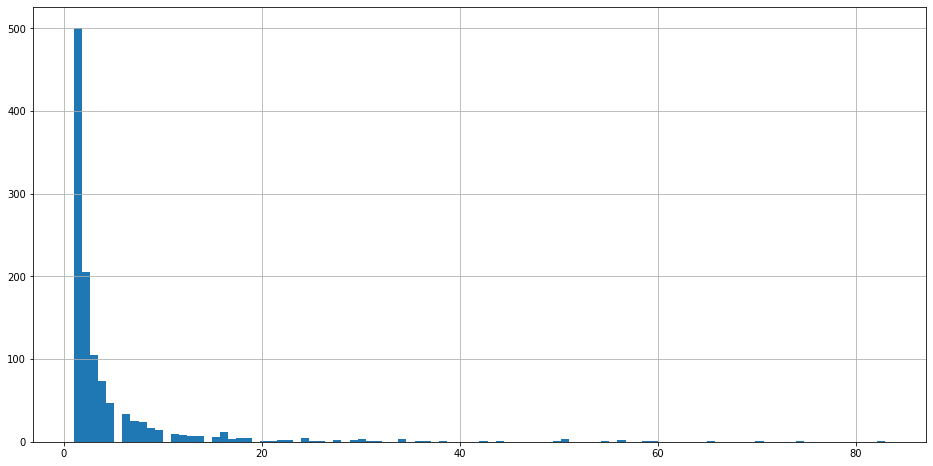

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
_ = all_moa_pd.target_id.value_counts().hist(bins=100)

In [31]:
all_moa_pd["community"] = None
for moa in tqdm(all_moa_pd.iterrows()):
    all_nscs = moa[1]["all_NSC"]
    chem_id = moa[1]["chem_id"]
    if all_nscs is None:
        continue
    response = graph.run(
        """
        MATCH (c:Chemical)
        WHERE c.nscNumber in $nscs
        RETURN c.community as community
        """, nscs = all_nscs
    ).data()
    if len(response) == 0:
        continue
    all_moa_pd.loc[all_moa_pd.chem_id == chem_id, 'community'] = response[0]["community"]

5140it [00:05, 938.30it/s] 


In [35]:
selected_moa = all_moa_pd.loc[all_moa_pd.community.notna()]
selected_moa

,target_id,chem_id,chem_name,mechanism_action_type,syn_name,syn_id,all_NSC,community
7,CHEMBL222,CHEMBL1200724,PSEUDOEPHEDRINE HYDROCHLORIDE,RELEASING AGENT,chembl1200724,81276db32c5339e1adb43d07c7756f1c,"[106567, 759616, 33634]",15158
8,CHEMBL5366,CHEMBL1094636,NIRAPARIB,INHIBITOR,chembl1094636,a313b67a5b44638ee61c2c30e78ec3eb,"[754355, 800020]",46475
13,CHEMBL2095165,CHEMBL252164,LUMINESPIB,INHIBITOR,chembl252164,70c7926b17740828f5be99bb91b86bbe,[755762],53142
14,CHEMBL2742,CHEMBL1201733,PAZOPANIB HYDROCHLORIDE,INHIBITOR,chembl1201733,6181d6610a472a9ad50678be0eee399d,[737754],46475
20,CHEMBL2107,CHEMBL18442,PLERIXAFOR,PARTIAL AGONIST,chembl18442,23f527e8b313312a08f6362c6918d932,"[761388, 754363]",15158
...,...,...,...,...,...,...,...,...
5130,CHEMBL1974,CHEMBL1721885,SU-014813,INHIBITOR,su-014813,f84aa622a49bca152e60229e9399787b,[800936],3362
5131,CHEMBL1936,CHEMBL1721885,SU-014813,INHIBITOR,su-014813,f84aa622a49bca152e60229e9399787b,[800936],3362
5133,CHEMBL2095203,CHEMBL2448612,ERGOTAMINE TARTRATE,AGONIST,ergotamine tartrate,4421f11d8bb61c7a36a169a87f984180,"[41869, 95090]",46475
5134,CHEMBL1991,CHEMBL3545089,IMD-0354,INHIBITOR,imd 0354,6eac82889d9f89baa0ec6f5537e77eef,"[816638, 800773]",3362


In [3]:
community_target_pivot = pd.pivot_table(selected_moa, values='chem_id', index='community',
                    columns='target_id', aggfunc="count", fill_value=0)

In [4]:
import numpy as np
colums, rows = np.where(community_target_pivot > 1)

In [51]:
selected_moa.to_csv(path_join("results", "all_selected_moa.json"))

In [2]:
selected_moa = pd.read_csv(path_join("results", "all_selected_moa.json"))

In [5]:
community_target_pivot.target_id[colums]

AttributeError: 'DataFrame' object has no attribute 'target_id'